In [1]:
import uproot
import tensorflow as tf
import zfit
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math

/opt/anaconda3/envs/m2_req/lib/python3.10/site-packages/zfit/__init__.py:59: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
data = zfit.Data.from_root("mu2e_caloSimu_crySpec867_TTREE.root", "specTree", ["spec", "ratio", "ntrig", "stim", "time", "tErg"]) #importing data from root file
energy_unbinned = data["spec"]

In [3]:
print("Bin count calc: range / # of bins")
print("Bin count in order to keep y axis as events per 25keV is: ",(8-1.5)*1000/25)
print("Events per x keV once combined binning method is used: ", (8-1.5)*1000/212)

Bin count calc: range / # of bins
Bin count in order to keep y axis as events per 25keV is:  260.0
Events per x keV once combined binning method is used:  30.660377358490567


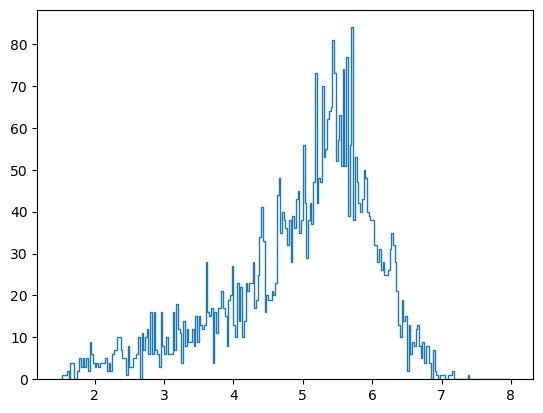

In [4]:
bin_count = 260 #trivially set depending on what we want the y axis to represent (x evts/kev)
energy_binned, bin_location, patches = plt.hist(energy_unbinned,bins=bin_count,histtype='step',range=(1.5,8)) #binning data and creating an x array of bin location

#### Parameters for 3 peaks

In [5]:
#parameters
cryspec = zfit.Space(['x'], limits=(1.5,8)) #obs range
ergElec = zfit.Parameter("electron energy", 0.511)
#ergElec = 0.511
fcbalpha = zfit.Parameter("fcbalpha", 2.5, 0.05, 20.0); #
fcbndeg = zfit.Parameter ("fcbndeg", 10, 0.25, 100);
A = zfit.Parameter ("A constant", 0.01, 0.005, 1);
B = zfit.Parameter ("B constant", 0.5, 0.005, 1);


#zfit.ComposedParameter definition for fractional resolution
def res_func(params):
    return tf.pow((tf.pow(params["a"]/tf.pow((params["peak"]/1000),0.25),2)),0.5) + (params["b"])**2 + (0.15/params["peak"])**2

def mult_list(params):
    return params["c"]*params["d"]

def subtract(params):
    return params["x"]-params["y"]

def EvnScd_func(params):
    return params["total"]-params["full"]-params["first"]

#full Peak
fullPeak = zfit.Parameter("full peak", 6, 5, 6.2); 
#fullRes = np.sqrt(pow(A/pow((fullPeak/1000),0.25),2)) + (B)**2 + (0.15/fullPeak)**2 #fractional resolution
fullRes = zfit.ComposedParameter("Composed Full frac Res",res_func , params = {"a":A, "b":B,"peak":fullPeak}) #[A,fullPeak,B]
#fullWidth = zfit.Parameter( "width of the full peak",fullPeak*fullRes ); 
fullWidth = zfit.ComposedParameter("width of the full peak",mult_list,params = {"c":fullPeak,"d":fullRes} ); 
EvnFull = zfit.Parameter("No. of Events in full peak", 500);

#frFull_sig = zfit.ComposedParameter('Full Peak fraction in signal', mult_list,params=[frFull, frsignal])

#params for fst peak
fstEsPeak = zfit.ComposedParameter("composed fst peak", subtract, params={"x":fullPeak,"y":ergElec})
fstRes = np.sqrt(pow(A/pow((fstEsPeak/1000),0.25),2)) + (B)**2 + (0.15/fstEsPeak)**2 #fractional resolution
fstWidth = zfit.Parameter("width of first escape peak",fstEsPeak*fstRes); 
EvnFrst = zfit.Parameter("No. of Events in first escape peak", 500);

#frFrst_sig = zfit.ComposedParameter('First Peak fraction in signal', mult_list,params=[frFrst, frsignal])

#params for scnd peak
scdEsPeak = zfit.ComposedParameter("composed scd peak", subtract, params={"x":fullPeak,"y":2*ergElec})
scdRes = tf.pow((tf.pow(A/tf.pow((scdEsPeak/1000),0.25),2)),0.5) + (B)**2 + (0.15/scdEsPeak)**2 #fractional resolution
scdWidth = zfit.Parameter("width of second escape peak", scdEsPeak*scdRes);
tot_evns = zfit.Parameter("Total # events", len(energy_unbinned),floating=False)
EvnScd = zfit.ComposedParameter("No. of Events in second escape peak", EvnScd_func, params={"total":tot_evns, "full":EvnFull,"first":EvnFrst});
#frScd_sig = zfit.ComposedParameter('Second Peak fraction in signal', mult_list,params=[frScd, frsignal])

#total signal parameter 
Evnsignal = zfit.Parameter("No. of Evns in combined signal", 1000,10,len(energy_unbinned))

print("Value of fullRes: ",fullRes)
print("Value of full width: ",fullWidth)
print(scdEsPeak)
print(fstRes)
#print(EvnScd)
print(EvnScd)

Value of fullRes:  <zfit.ComposedParameter 'Composed Full frac Res' params=[('a', 'A constant'), ('b', 'B constant'), ('peak', 'full peak')] value=0.2866>
Value of full width:  <zfit.ComposedParameter 'width of the full peak' params=[('c', 'full peak'), ('d', 'Composed Full frac Res')] value=1.719>
<zfit.ComposedParameter 'composed scd peak' params=[('x', 'full peak'), ('y', 'FIXED_autoparam_0')] value=4.978>
tf.Tensor(0.28748573177410386, shape=(), dtype=float64)
<zfit.ComposedParameter 'No. of Events in second escape peak' params=[('total', 'Total # events'), ('full', 'No. of Events in full peak'), ('first', 'No. of Events in first escape peak')] value=3681>


#### Logistic background

In [6]:
#logistic background parameters
comCnst = zfit.Parameter("comCnst", 4, 1, 20)
combeta = zfit.Parameter("combeta", 1, 0.01, 30)
EvnBG = zfit.ComposedParameter("Fraction of logistic background",subtract, params={"x":tot_evns,"y":Evnsignal})
#EvnBG = zfit.Parameter("No. of Evns in logistic background",len(energy_unbinned)- EvnFull-EvnFrst-EvnScd)

#frBG = zfit.Parameter("Fraction of logistic background",1-frsignal)

In [7]:
class bckgrndPDF(zfit.pdf.ZPDF):
    _N_OBS = 1
    _PARAMS = ['comCnst3', 'combeta3']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x = zfit.z.unstack_x(x)
        comCnst = self.params['comCnst3']
        combeta = self.params['combeta3']
        return 1.0/(1.0+tf.math.exp((x-comCnst)/combeta))

#### Range, Scale and Limits

In [8]:
lower, upper = cryspec.limits
x_range= cryspec.area()

#the pdfs below are normalised to =1 so must apply scaling factor 
scale = (len(energy_unbinned)/bin_count)*x_range

#TODO:: integrate from low bin edge to high bin edge instead of using bin center
bin_centers =  (bin_location[1:] + bin_location[:-1])/2

#### PDF Definition

In [9]:
fullErg = zfit.pdf.CrystalBall(obs=cryspec, mu=fullPeak, sigma=fullWidth, alpha=fcbalpha, n=fcbndeg, extended=EvnFull)
#extended= frfull*frsignal does not work in the minimiser-- solution: make extended = # number pf events and when plotting pdf/total # events
firstErg = zfit.pdf.CrystalBall(obs=cryspec,mu=fstEsPeak,sigma=fstWidth,alpha=fcbalpha, n=fcbndeg, extended=EvnFrst)
secdErg = zfit.pdf.CrystalBall(obs=cryspec, mu=scdEsPeak, sigma=scdWidth, alpha=fcbalpha, n=fcbndeg, extended=EvnScd)
background = bckgrndPDF(obs=cryspec, comCnst3=comCnst,combeta3=combeta, extended = EvnBG)
signal_fit = zfit.pdf.SumPDF([fullErg,firstErg,secdErg],obs=cryspec,extended = True)
comb_fit = zfit.pdf.SumPDF([fullErg,firstErg,secdErg,background],obs=cryspec,extended = True)

#### Running PDF

In [10]:
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_first = firstErg.pdf(bin_centers,norm_range=cryspec)
y_plot_secd = secdErg.pdf(bin_centers,norm_range=cryspec)
y_plot_comb = comb_fit.pdf(bin_centers,norm_range=cryspec)
y_plot_logistic = background.pdf(bin_centers,norm_range=cryspec)
y_plot_signal = signal_fit.pdf(bin_centers,norm_range=cryspec)

Text(0.5, 0, 'E_reco [MeV]')

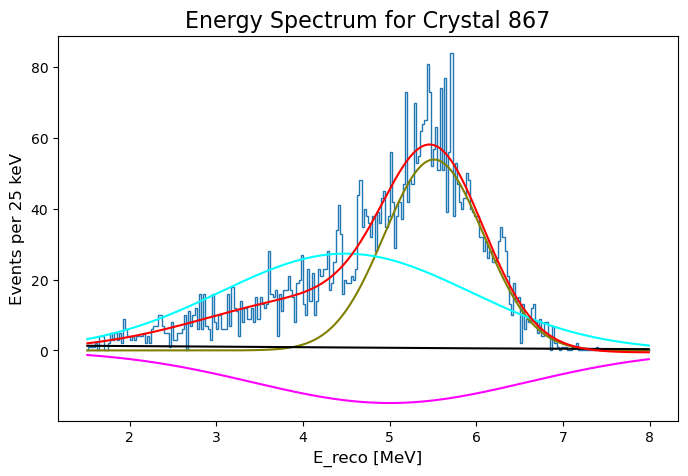

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hist(energy_unbinned,bins=bin_count,histtype='step',range=(1.5,8))

plt.plot(bin_centers, y_plot_full*scale*EvnFull/len(energy_unbinned), color="olive", label='Full Peak CB')
plt.plot(bin_centers, y_plot_first*scale*EvnFrst/len(energy_unbinned), color="magenta",label='1st Esc Peak')
plt.plot(bin_centers, y_plot_secd*scale*EvnScd/len(energy_unbinned), color="cyan",label='2nd Esc Peak')
#logistic background
plt.plot(bin_centers, y_plot_logistic*scale*EvnBG/len(energy_unbinned), color="black", label='Full Peak CB')

#Combined Fit
plt.plot(bin_centers, y_plot_comb*scale, color="red",label='Combined Fit')

#plt.plot(bin_centers, y_plot_signal*scale, color="orange",label='Combined Fit')


#chi sq goodness of fit test

#plt.text(2,60,"\u03C7\u00B2/ndf:"+str(round((comb_chisq[0]/(len(energy_binned))),2)),fontsize=14)
#plt.text(2,50,"p_value: "+str(round(comb_chisq[1],10)),fontsize=14)

plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)

In [22]:
#check to see if sum of binned data is accurate length of unbinned data
print("Sum of binned data:",np.sum(energy_binned))
print("Length of unbinned data",len(energy_unbinned))
alldata_integral = scipy.integrate.trapz(y_plot_comb*scale)
print("Integral of crystal ball fit =",alldata_integral)

Sum of binned data: 4681.0
Length of unbinned data 4681
Integral of crystal ball fit = 4680.266776713722


In [23]:

#constraint = zfit.core.constraint.SimpleConstraint(EvnFull+EvnFrst+EvnScd+EvnBG==len(energy_unbinned),params=[EvnFull,EvnFrst,EvnScd,EvnBG])

nll_comb = zfit.loss.ExtendedUnbinnedNLL(model=comb_fit, data=energy_unbinned)#, constraints=constraint)

minimizer = zfit.minimize.Minuit()

result = minimizer.minimize(nll_comb, params=[A,B,fcbalpha,fcbndeg,
                                                  fullPeak,EvnFull,
                                                  EvnFrst, Evnsignal,
                                                  comCnst,combeta])#there should be only 3 fr param- make frBG sum of others

#below are attempted methods to calculate erros
#param_hesse = result.errors()
#errors=zfit.minimizers.errors(result)
#errors=result.hesse(method='hesse_np', name='hesse')
#errors=result.hesse(method='minuit_hesse', name='hesse')
#errors = zfit.result.compute_erros(result,params=[A,B,fcbalpha,fcbndeg,fullPeak,frFull,frFrst,frBG,comCnst,combeta])

print(result)
print(fullWidth)
print(fstWidth)
print(scdWidth)
print('----------')
print("Actual value of Frst Peak:",fstEsPeak)
print("Actual value of Scnd Peak:",scdEsPeak)
print("Expected value of Frst Peak:",fullPeak-0.511)
print("Expected value of scnd Peak:",fullPeak-2*0.511)
print('--------')
print(fullRes)
print(fstRes)
print(scdRes)
print('--------')
print(EvnScd)
print(EvnBG)
print('--------')
print("Total # of evts:",len(energy_unbinned))
print("Total Sum of all 4 fractions: ", EvnFull+EvnFrst+EvnScd+EvnBG)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_6, Composed_autoparam_7, Composed_autoparam_8, Composed_autoparam_9]] data=[<zfit.Data: Data obs=('x',) shape=(4681, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  False  │    True     │       True       │ 6.3e-06 │        -28460.89 |  10008.21 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name                                  value  (rounded)    at limit
----------------------------------  ------------------  ----------
A constant                                   0.0130122       False
B constant                                    0.242765       False
fcbalph

nll_signal = zfit.loss.ExtendedUnbinnedNLL(model=signal_fit, data=energy_unbinned)#, constraints=constraint)

minimizer = zfit.minimize.Minuit()

results_signal = minimizer.minimize(nll_signal, params=[Evnsignal])
param_hesse = result_signal.errors()
print(result_signal)


In [14]:
# running pdfs again to load the minimized values of params
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_first = firstErg.pdf(bin_centers,norm_range=cryspec)
y_plot_secd = secdErg.pdf(bin_centers,norm_range=cryspec)
y_plot_comb = comb_fit.pdf(bin_centers,norm_range=cryspec)
y_plot_logistic = background.pdf(bin_centers,norm_range=cryspec)

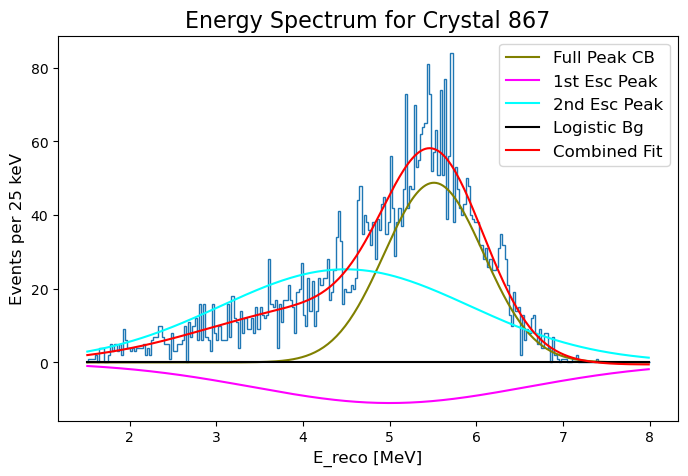

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
energy_binned, bin_location, patches = ax.hist(energy_unbinned,
                           bins=(bin_count),histtype='step',
                           range=(1.5,8))

plt.plot(bin_centers, y_plot_full*scale*EvnFull/len(energy_unbinned), color="olive", label='Full Peak CB')
plt.plot(bin_centers, y_plot_first*scale*EvnFrst/len(energy_unbinned), color="magenta",label='1st Esc Peak')
plt.plot(bin_centers, y_plot_secd*scale*EvnScd/len(energy_unbinned), color="cyan",label='2nd Esc Peak')
#logistic background
plt.plot(bin_centers, y_plot_logistic*scale*EvnBG/len(energy_unbinned), color="black", label='Logistic Bg')

#Combined Fit
plt.plot(bin_centers, y_plot_comb*scale, color="red",label='Combined Fit')


#adding text box with chi sq, pvalue and ndof 
#plt.text(1.5,70,"\u03C7\u00B2/ndf:"+str(round((comb_chisq_min[0]/(len(energy_binned))),2)),fontsize=14)
#plt.text(1.5,60,"ndf: "+str(round((len(energy_binned)),2)),fontsize=14)
#plt.text(1.5,50,"p_value: "+str(round(comb_chisq_min[1],10)),fontsize=14)

plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)
leg = plt.legend(fontsize=12);